# Calculate CAA scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()

warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
# Concentration of dMn in 2015
# Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Fe&Mn_Integrated_Data_UBC-UVic_4-17-19_editedBR.csv')
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float')
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float')
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float')

Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [38]:
# Load particulate data
pMn_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
stns = pMn_data['GEOTR_STN'].astype('str')

For each station, find a similar depth:

In [44]:
def assoc_depth(name):
    
    pMn_stn   = pMn_data['Mn (pmol/L)'].where(stns == name).dropna().astype('float').values*1e-3
    dMn_stn   = Manuel_dMn_nmolL[Manuel_station_names==name].values
    depth_pMn = pMn_data['CTDPRS (DBAR)'].where(stns == name).dropna().astype('float').values
    depth_dMn = Manuel_depths[Manuel_station_names==name].values
    
    if len(depth_pMn) > len(depth_dMn):
        depth_list    = np.array(depth_pMn)
        depth_shorter = np.array(depth_dMn)
    else:
        depth_list    = np.array(depth_dMn)
        depth_shorter = np.array(depth_pMn)

    depths= np.empty_like(depth_list)
    pMn   = np.empty_like(depth_list)
    dMn   = np.empty_like(depth_list)
    i=0

    for depth in depth_list:
        min_val  = np.argmin(np.abs(depth_shorter - depth))
        
        if np.abs(depth_shorter[min_val] - depth) > 100:
            depths[i] = np.nan
            pMn[i]    = np.nan
            dMn[i]    = np.nan
        else:
            depths[i] = depth_shorter[min_val]
            if len(depth_pMn) > len(depth_dMn):
                pMn[i]    = pMn_stn[i]
                dMn[i]    = dMn_stn[min_val]                
            else:
                pMn[i]    = pMn_stn[min_val]
                dMn[i]    = dMn_stn[i] #indexed starting with 1 instead of 0 (removed + 1)
        i+=1
        
    return depths, pMn, dMn

In [45]:
# 2015: no pMn data for CAA2
depths_CAA1, pmn_CAA1, dmn_CAA1 = assoc_depth('CAA1')
depths_CAA3, pmn_CAA3, dmn_CAA3 = assoc_depth('CAA3')
depths_CAA4, pmn_CAA4, dmn_CAA4 = assoc_depth('CAA4')
depths_CAA5, pmn_CAA5, dmn_CAA5 = assoc_depth('CAA5')
depths_CAA6, pmn_CAA6, dmn_CAA6 = assoc_depth('CAA6')
depths_CAA7, pmn_CAA7, dmn_CAA7 = assoc_depth('CAA7')
depths_CAA8, pmn_CAA8, dmn_CAA8 = assoc_depth('CAA8')
depths_CAA9, pmn_CAA9, dmn_CAA9 = assoc_depth('CAA9')

depths_CB1, pmn_CB1, dmn_CB1 = assoc_depth('CB1')
depths_CB2, pmn_CB2, dmn_CB2 = assoc_depth('CB2')
depths_CB3, pmn_CB3, dmn_CB3 = assoc_depth('CB3')
depths_CB4, pmn_CB4, dmn_CB4 = assoc_depth('CB4')

depths_BB1, pmn_BB1, dmn_BB1 = assoc_depth('BB1')
depths_BB2, pmn_BB2, dmn_BB2 = assoc_depth('BB2')
depths_BB3, pmn_BB3, dmn_BB3 = assoc_depth('BB3')

## Calculating scavenging rates:

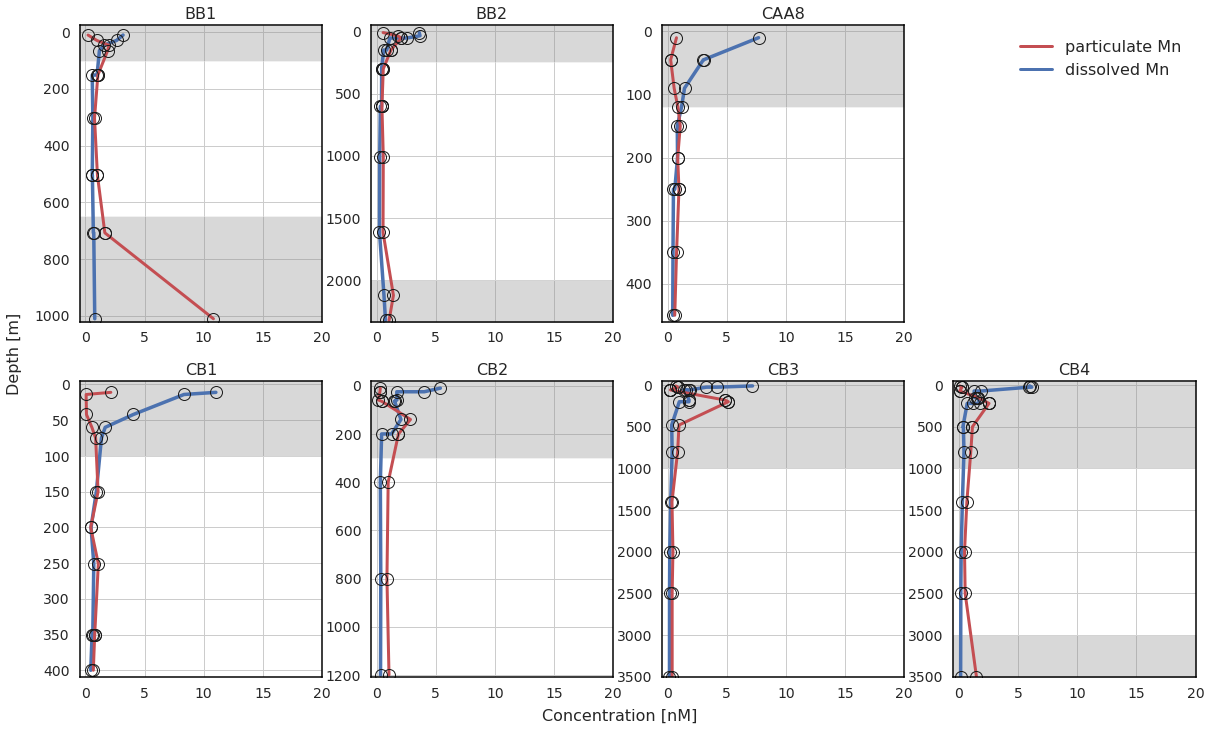

In [47]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(2,4, figsize=(20,12))
    for axs in ax[0,:]:
        axs.invert_yaxis()
        axs.set_xlim([-0.5, 20])
        axs.tick_params(axis='both', which='major', labelsize=14)
        axs.set_xticks([0,5,10,15,20])
        axs.spines['left'].set_linewidth(1.5);   axs.spines['left'].set_color('black');
        axs.spines['bottom'].set_linewidth(1.5); axs.spines['bottom'].set_color('black');
        axs.spines['right'].set_linewidth(1.5);  axs.spines['right'].set_color('black');
        axs.spines['top'].set_linewidth(1.5);    axs.spines['top'].set_color('black');

    for axs in ax[1,:]:
        axs.invert_yaxis()
        axs.set_xlim([-0.5, 20])
        axs.tick_params(axis='both', which='major', labelsize=14)
        axs.set_xticks([0,5,10,15,20])
        axs.spines['left'].set_linewidth(1.5);   axs.spines['left'].set_color('black');
        axs.spines['bottom'].set_linewidth(1.5); axs.spines['bottom'].set_color('black');
        axs.spines['right'].set_linewidth(1.5);  axs.spines['right'].set_color('black');
        axs.spines['top'].set_linewidth(1.5);    axs.spines['top'].set_color('black');

    ax[0,3].axis('off')
    
    ax[0,0].plot(dmn_BB1[~np.isnan(dmn_BB1)], depths_BB1[~np.isnan(dmn_BB1)], '-', linewidth=3.5)
    ax[0,1].plot(dmn_BB2[~np.isnan(dmn_BB2)], depths_BB2[~np.isnan(dmn_BB2)], '-', linewidth=3.5)
    ax[0,2].plot(dmn_CAA8[~np.isnan(dmn_CAA8)], depths_CAA8[~np.isnan(dmn_CAA8)], '-', linewidth=3.5)
    ax[0,0].plot(pmn_BB1[~np.isnan(pmn_BB1)], depths_BB1[~np.isnan(pmn_BB1)], '-r', linewidth=3.0)
    ax[0,1].plot(pmn_BB2[~np.isnan(pmn_BB2)], depths_BB2[~np.isnan(pmn_BB2)], '-r', linewidth=3.0)
    ax[0,2].plot(pmn_CAA8[~np.isnan(pmn_CAA8)], depths_CAA8[~np.isnan(pmn_CAA8)], '-r', linewidth=3.0)
    ax[0,0].plot(dmn_BB1[~np.isnan(dmn_BB1)], depths_BB1[~np.isnan(dmn_BB1)], 'ok', fillstyle='none', markersize=12)
    ax[0,1].plot(dmn_BB2[~np.isnan(dmn_BB2)], depths_BB2[~np.isnan(dmn_BB2)], 'ok', fillstyle='none', markersize=12)
    ax[0,2].plot(dmn_CAA8[~np.isnan(dmn_CAA8)], depths_CAA8[~np.isnan(dmn_CAA8)], 'ok', fillstyle='none', markersize=12)
    ax[0,0].plot(pmn_BB1[~np.isnan(pmn_BB1)], depths_BB1[~np.isnan(pmn_BB1)], 'ok', fillstyle='none', markersize=12)
    ax[0,1].plot(pmn_BB2[~np.isnan(pmn_BB2)], depths_BB2[~np.isnan(pmn_BB2)], 'ok', fillstyle='none', markersize=12)
    ax[0,2].plot(pmn_CAA8[~np.isnan(pmn_CAA8)], depths_CAA8[~np.isnan(pmn_CAA8)], 'ok', fillstyle='none', markersize=12)

    ax[1,0].plot(dmn_CB1[~np.isnan(dmn_CB1)], depths_CB1[~np.isnan(dmn_CB1)], '-', linewidth=3.5)
    ax[1,1].plot(dmn_CB2[~np.isnan(dmn_CB2)], depths_CB2[~np.isnan(dmn_CB2)], '-', linewidth=3.5)
    ax[1,2].plot(dmn_CB3[~np.isnan(dmn_CB3)], depths_CB3[~np.isnan(dmn_CB3)], '-', linewidth=3.5)
    ax[1,3].plot(dmn_CB4[~np.isnan(dmn_CB4)], depths_CB4[~np.isnan(dmn_CB4)], '-', linewidth=3.5)
    ax[1,0].plot(pmn_CB1[~np.isnan(pmn_CB1)], depths_CB1[~np.isnan(pmn_CB1)], '-r', linewidth=3.0)
    ax[1,1].plot(pmn_CB2[~np.isnan(pmn_CB2)], depths_CB2[~np.isnan(pmn_CB2)], '-r', linewidth=3.0)
    ax[1,2].plot(pmn_CB3[~np.isnan(pmn_CB3)], depths_CB3[~np.isnan(pmn_CB3)], '-r', linewidth=3.0)
    ax[1,3].plot(pmn_CB4[~np.isnan(pmn_CB4)], depths_CB4[~np.isnan(pmn_CB4)], '-r', linewidth=3.0)
    ax[1,0].plot(dmn_CB1[~np.isnan(dmn_CB1)], depths_CB1[~np.isnan(dmn_CB1)], 'ok', fillstyle='none', markersize=12)
    ax[1,1].plot(dmn_CB2[~np.isnan(dmn_CB2)], depths_CB2[~np.isnan(dmn_CB2)], 'ok', fillstyle='none', markersize=12)
    ax[1,2].plot(dmn_CB3[~np.isnan(dmn_CB3)], depths_CB3[~np.isnan(dmn_CB3)], 'ok', fillstyle='none', markersize=12)
    ax[1,3].plot(dmn_CB4[~np.isnan(dmn_CB4)], depths_CB4[~np.isnan(dmn_CB4)], 'ok', fillstyle='none', markersize=12)
    ax[1,0].plot(pmn_CB1[~np.isnan(pmn_CB1)], depths_CB1[~np.isnan(pmn_CB1)], 'ok', fillstyle='none', markersize=12)
    ax[1,1].plot(pmn_CB2[~np.isnan(pmn_CB2)], depths_CB2[~np.isnan(pmn_CB2)], 'ok', fillstyle='none', markersize=12)
    ax[1,2].plot(pmn_CB3[~np.isnan(pmn_CB3)], depths_CB3[~np.isnan(pmn_CB3)], 'ok', fillstyle='none', markersize=12)
    ax[1,3].plot(pmn_CB4[~np.isnan(pmn_CB4)], depths_CB4[~np.isnan(pmn_CB4)], 'ok', fillstyle='none', markersize=12)
    
    #grey boxes:
    ax[0,0].fill_between([-2,20], [-25,-25], [100,100], facecolor='grey', alpha=0.3)
    ax[0,0].fill_between([-2,20], [650,650], [np.nanmax(depths_BB1)+80, np.nanmax(depths_BB1)+80], facecolor='grey', alpha=0.3)
    ax[0,0].set_ylim([np.nanmax(depths_BB1)+10, -25])
    ax[0,1].fill_between([-2,20], [-50,-50] , [250, 250], facecolor='grey', alpha=0.3)
    ax[0,1].fill_between([-2,20], [2000,2000], [np.nanmax(depths_BB2)+80, np.nanmax(depths_BB2)+80], facecolor='grey', alpha=0.3)
    ax[0,1].set_ylim([np.nanmax(depths_BB2)+10, -50])
    ax[0,2].fill_between([-2,20], [-10,-10]    , [120, 120], facecolor='grey', alpha=0.3)
    ax[0,2].set_ylim([np.nanmax(depths_CAA8)+10, -10])

    ax[1,0].fill_between([-2,20], [-10,-10]  ,[100,100], facecolor='grey', alpha=0.3)
    ax[1,0].set_ylim([np.nanmax(depths_CB1)+10, -5])
    ax[1,1].fill_between([-2,20], [-20,-20]  ,[300,300], facecolor='grey', alpha=0.3)
    ax[1,1].set_ylim([np.nanmax(depths_CB2)+10, -20])
    ax[1,2].fill_between([-2,20], [-50,-50]  ,[1000,1000], facecolor='grey', alpha=0.3)
    ax[1,2].set_ylim([np.nanmax(depths_CB3)+10, -50])
    ax[1,3].fill_between([-2,20], [-50,-50]  ,[1000,1000], facecolor='grey', alpha=0.3)
    ax[1,3].fill_between([-2,20], [3000,3000], [np.nanmax(depths_CB4)+80, np.nanmax(depths_CB4)+80], facecolor='grey', alpha=0.3)
    ax[1,3].set_ylim([np.nanmax(depths_CB4)+10, -50])
    
    ax[0,3].plot(-1,2, '-r', linewidth=3, label='particulate Mn')
    ax[0,3].plot(-1,2, '-', linewidth=3, label='dissolved Mn')

    ax[0,0].set_title('BB1', fontsize=16)
    ax[0,1].set_title('BB2', fontsize=16)
    ax[0,2].set_title('CAA8', fontsize=16)
    ax[1,0].set_title('CB1', fontsize=16)
    ax[1,1].set_title('CB2', fontsize=16)
    ax[1,2].set_title('CB3', fontsize=16)
    ax[1,3].set_title('CB4', fontsize=16)

    ax[0,3].legend(frameon=False, fontsize=16)
    
    fig.text(0.5, 0.08, 'Concentration [nM]', ha='center', va='center', fontsize=16)
    fig.text(0.08, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical', fontsize=16)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S4-scavenging-stns.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S4-scavenging-stns.svg', bbox_inches='tight', dpi=300, format='svg')

In [48]:
dmn = np.concatenate((dmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)], \
                      dmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                      dmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                      dmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                      dmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                      dmn_CB3[depths_CB3 > 500], \
                      dmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)]))
pmn = np.concatenate((pmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)], \
                      pmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                      pmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                      pmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                      pmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                      pmn_CB3[depths_CB3 > 500], \
                      pmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)]))

In [49]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dmn, pmn)

print(slope, intercept, r_value**2)

0.8009410388520477 0.37226592608312453 0.5148392664032022


In [50]:
import statsmodels.api as sm


xp      = np.linspace(0,1.0,20)
xp_fit  = xp.reshape((-1, 1)) 
dmn_fit = dmn.reshape((-1, 1))
pmn_fit = pmn

ols = sm.OLS(pmn_fit, dmn_fit)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                              324.4
Date:                Tue, 10 Aug 2021   Prob (F-statistic):                    2.61e-18
Time:                        16:05:34   Log-Likelihood:                          1.1555
No. Observations:                  33   AIC:                                    -0.3110
Df Residuals:                      32   BIC:                                      1.186
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4610      0.081     18.012      0.000       1.296       1.626
==============================================================================
Omnibus:                        0.034   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.101
Skew:                          -0.053   Prob(JB):                        0.951
Kurtosis:                       2.751   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
xp      = np.linspace(0,1.0,20)
xp_fit  = xp.reshape((-1, 1)) 
dmn_fit = dmn.reshape((-1, 1))
pmn_fit = pmn
model   = LinearRegression(fit_intercept=False).fit(dmn_fit, pmn_fit)
r_sq    = model.score(dmn_fit, pmn_fit)
yp_pred = model.predict(xp_fit)
print('slope: ', model.coef_)
# print('score: ', model.score)

slope:  [1.46101468]


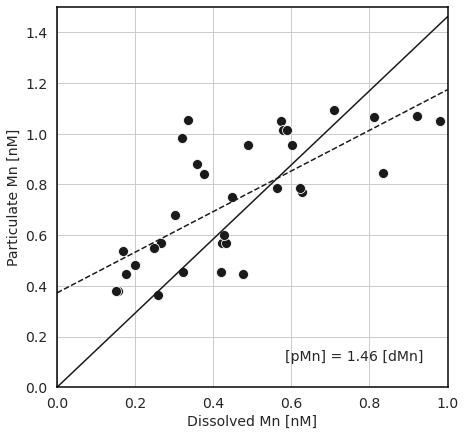

In [57]:
fig = plt.figure(figsize=(7,7))

st = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(xp, yp_pred, c='k')

    sns.scatterplot(dmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)],  \
                    pmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)],  s=100, color='k')
    sns.scatterplot(dmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                    pmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], s=100, color='k')
    sns.scatterplot(dmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                    pmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], s=100, color='k')
    sns.scatterplot(dmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                    pmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], s=100, color='k')
    sns.scatterplot(dmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                    pmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], s=100, color='k')
    sns.scatterplot(dmn_CB3[depths_CB3 > 500], \
                    pmn_CB3[depths_CB3 > 500], s=100, color='k')
    sns.scatterplot(dmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)], \
                    pmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)], s=100, color='k')
    
    sns.lineplot(xp, xp*slope + intercept, c='k', linestyle='--')

    ax.set_ylabel('Particulate Mn [nM]', fontsize=14)
    ax.set_xlabel('Dissolved Mn [nM]', fontsize=14)
    ax.set(ylim=(0,1.5), xlim=(0,1.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    ax.text(0.76, 0.08,f'[pMn] = {model.coef_[0]:.2f} [dMn]', fontsize=14, horizontalalignment='center', \
            verticalalignment='center', transform=ax.transAxes);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/A2-scavenging-rate.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/A2-scavenging-rate.svg', bbox_inches='tight', dpi=300, format='svg')

In [68]:
print(f'{np.mean(pmn)/np.mean(dmn):.2f}')
print(f'{np.mean(pmn):.2f}')
print(f'{np.mean(dmn):.2f}')

1.61
0.74
0.46


slope:  [1.47895544]
score:  <bound method RegressorMixin.score of LinearRegression(fit_intercept=False)>


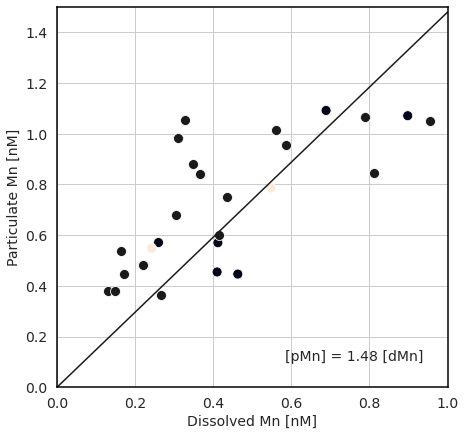

In [76]:
fig = plt.figure(figsize=(7,7))

xp      = np.linspace(0,1.0,20)
xp_fit  = xp.reshape((-1, 1)) 
dmn_fit = dmn.reshape((-1, 1))
pmn_fit = pmn
model   = LinearRegression(fit_intercept=False).fit(dmn_fit, pmn_fit)
r_sq    = model.score(dmn_fit, pmn_fit)
yp_pred = model.predict(xp_fit)
print('slope: ', model.coef_)
print('score: ', model.score)


st = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(xp, yp_pred, c='k')

    sns.scatterplot(dmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)],  \
                    pmn_BB1[(depths_BB1 > 100) & (depths_BB1 < 650)],  s=100, color='k')
    sns.scatterplot(dmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], \
                    pmn_BB2[(depths_BB2 > 250) & (depths_BB2 < 2000)], s=100, color='k')
    sns.scatterplot(dmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], \
                    pmn_CAA8[(depths_CAA8 > 120) & (depths_CAA8 < 500)], s=100, color='k')
    sns.scatterplot(dmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], \
                    pmn_CB1[(depths_CB1 > 100) & (depths_CB1 < 400)], s=100, color='k')
    sns.scatterplot(dmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], \
                    pmn_CB2[(depths_CB2 > 300) & (depths_CB2 < 1250)], s=100, color='k')
    sns.scatterplot(dmn_CB3[depths_CB3 > 500], \
                    pmn_CB3[depths_CB3 > 500], s=100, color='k')
    sns.scatterplot(dmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)], \
                    pmn_CB4[(depths_CB4 > 1000) & (depths_CB4 < 3000)], s=100, color='k')

    ax.set_ylabel('Particulate Mn [nM]', fontsize=14)
    ax.set_xlabel('Dissolved Mn [nM]', fontsize=14)
    ax.set(ylim=(0,1.5), xlim=(0,1.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    ax.text(0.76, 0.08,'[pMn] = 1.48 [dMn]', fontsize=14, horizontalalignment='center', \
            verticalalignment='center', transform=ax.transAxes);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S5-scavenging-rate.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S5-scavenging-rate.svg', bbox_inches='tight', dpi=300, format='svg')